
#Welcome to Backprojection T cell
##Run all the cells in order


In [1]:
!pip install rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314904 sha256=abc58e4cf2a9ec990094703586d45e2868f904e385dcd58f65dca6c8ee6576bd
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [2]:
%load_ext rpy2.ipython

#Importing Packages

In [4]:
%%R

set.seed(12)
getwd()

install.packages('plyr')
install.packages('readr')
install.packages('dplyr')
install.packages('reshape2')
install.packages('zoo')
install.packages('spatstat')
install.packages('sp')
install.packages('stats')
install.packages('yaml')
install.packages('optparse')
install.packages('ggplot2')


library(plyr)
library(readr)
library(dplyr)
library(reshape2)
library(zoo)
library(spatstat)
library(sp)
library(stats)
library(yaml)
library(optparse)
library(ggplot2)

### Set to TRUE if you want to run import and processing even if file already exists
#force_redo=TRUE
tracks_provided=NULL


(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)





























	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)





























	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)










































































	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)



















	‘/tmp/Rtmpd8QHbf/downloaded_packages’

Attaching package: ‘dplyr’



    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




#Uploading Files depending on location

###If files are in local:
#####A) Either load the files to Google Colab directly using the Google Colab feature in the image shown below. And then continue with the rest of the code.
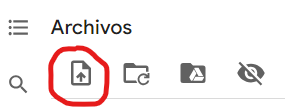
#####B) Upload to your Google Drive the files, and go to the previous step. And then continue with the following code.
#####Google Drive Accession:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Location of File in Google Drive
###Regardless from your files original location, your files are now in Google Colab. To the left hand side of your screen you will see your files. Paste on each space provided, the url where the data is (Data_dir), where you want the results to be uploaded (Output_dir) and the metadata from which the analysis will start (Metadata_dir).
######PD: The link can be obtained by right clicking the directory/file and clicking on "copy path".

In [5]:
%%R
Data_dir <- "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/data" #@param {type:"string"}
Output_dir <- "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/example_output" #@param {type:"string"}
Metadata_dir <- "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/BEHAV3D_metadata.tsv" #@param {type:"string"}


reference_map <- "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/references/Behavioral_Referance_map_git" #@param {type:"string"}
model_output_path <- "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/references/TrainedRandomForest.Rdata" #@param {type:"string"}


#Parameters

In [6]:
%%R
#@title Parameters to change, if not, they are set to the default values (bars are set to defaul already, only change if you know what you are doing)
tcell_exp_duration <- 400 #@param {type:"slider", min:0, max:600, step:1}
tcell_min_track_length <- 60 #@param {type:"slider", min:0, max:100, step:1}
tcell_max_track_length <- 60 #@param {type:"slider", min:0, max:100, step:1}
time_interval <- 2 #@param {type:"slider", min:0, max:60, step:1}





#Import and Process Data **if "processed_tcell_track_data.rds" DOESNT exist** in the output folder. (If it already exists skip this step)

In [7]:
%%R

data_dir<-Data_dir
output_dir<-Output_dir

### Setting data directory (if specified) and creating output directories
data_dir = paste0(data_dir,"/")
qc_output_dir = paste0(output_dir,"/tcell_behavior/quality_control/")
output_dir=paste0(output_dir,"/tcell_behavior/results/")
#dir.create(qc_output_dir, recursive=TRUE)
#dir.create(output_dir, recursive=TRUE)
model_path <- model_output_path



In [8]:
%%R

print("#################################################")
print("###############  Importing data  ################")
print("#################################################")
### Function to count the number of tracks in the dataset
count_tracks = function (track_table){
  # nr_tracks_unfilt=track_table
  # nr_tracks_unfilt$name = paste(nr_tracks_unfilt$organoid_line, nr_tracks_unfilt$tcell_line, nr_tracks_unfilt$exp_nr, nr_tracks_unfilt$well)
  nr_tracks_unfilt = track_table %>%
    group_by(basename, organoid_line, tcell_line, exp_nr, well) %>%
    dplyr::summarize(
      nr_tracks=length(unique(TrackID))
    ) %>%
    ungroup()
}


###############################
######### Data import #########
###############################

### Import file-specific metadata for all images used in this analysis.
pat = Metadata_dir
metadata=read.csv(Metadata_dir, sep="\t", check.names=FALSE)

track_counts=metadata
track_counts$name = paste(metadata$organoid_line, metadata$tcell_line, metadata$exp_nr, metadata$well)
track_counts=track_counts[,c("basename", "name", "organoid_line")]

### Check if folder with statistics is named in the metadata table, if not, try default naming of data basename + "_Statistics"
if ( any(is.na(metadata$tcell_stats_folder)) ){
  metadata$tcell_stats_folder=apply(metadata, 1, function(x) paste0(data_dir, x["basename"], "_Statistics"))
}

read_ims_csv <- function(metadata_row, pattern) {
  read_plus <- function(flnm, stat_folder) {
    read_csv(flnm, skip = 3, col_types = cols(TrackID= col_character())) %>%
      mutate(filename = flnm, stat_folder=stat_folder, basename=basename)
  }
  basename=gsub("([.|()\\^{}+$*?]|\\[|\\])", "\\\\\\1", metadata_row[['basename']])
  pattern <- paste0(basename,".*", pattern, ".*")
  pattern_file <- list.files(path = metadata_row[['stats_folder']], pattern = pattern, full.names=TRUE)
  if (identical(pattern_file, character(0))){
    print(paste("No file with pattern '", pattern, "' found for", metadata_row['stats_folder']))
  }
  print(pattern_file)
  ims_csv <- read_plus(pattern_file, metadata_row['stats_folder'])
  return(ims_csv)
}


stat_folders <- metadata[c("basename", "tcell_stats_folder")]
colnames(stat_folders) <- c("basename", "stats_folder")

# import Displacement^2
pat = "Displacement\\^2"
displacement=do.call("rbind", apply(stat_folders, 1, read_ims_csv, pattern=pat))

# import Speed
pat = "Speed"
speed <- do.call("rbind", apply(stat_folders, 1, read_ims_csv, pattern=pat))

# import mean dead dye intensity values
datalist = list()
for (i in 1:length(stat_folders$stats_folder)){
  pat=paste0("Intensity_Mean_Ch=", metadata$dead_dye_channel[i], "_Img=1")
  img_csv = read_ims_csv(stat_folders[i,], pattern=pat)
  if (!identical(img_csv, character(0))){
    datalist[[i]]=img_csv
  }
}
red_lym=do.call(rbind, datalist)

# import distance to organoids (if calculated with distance transformation or with object distance)

datalist2 = list()

for (i in 1:length(stat_folders$stats_folder)) {
    if (metadata$Object_distance[i] == TRUE) {
    # import Object distance to organoids
    pat <- paste0("Shortest_Distance_to_Surfaces_Surfaces=", metadata$tumor_name[i])
    img_csv <- read_ims_csv(stat_folders[i,], pattern = pat)
    if (!identical(img_csv, character(0))) {
      datalist2[[i]] <- img_csv
    }
  } else {
    # import Minimal distance to organoids (distance transformation channel)
    pat <- paste0("Intensity_Min_Ch=", metadata$organoid_distance_channel[i], "_Img=1")
    img_csv <- read_ims_csv(stat_folders[i,], pattern = pat)
    if (!identical(img_csv, character(0))) {
      datalist2[[i]] <- img_csv
    }
  }
}
dist_org = do.call(rbind, datalist2)

# import Position
pat = "Position"
pos <- do.call("rbind", apply(stat_folders, 1, read_ims_csv, pattern=pat))

### Join all Imaris information
master <- cbind(
  displacement[,c("Displacement^2","Time","TrackID" ,"ID")],
  speed[,c("Speed" )],
  dist_org[,c(1)],
  red_lym[,c("Intensity Mean")],
  pos[,c("Position X" ,"Position Y" ,"Position Z","filename", "stat_folder", "basename")]
)

### Get the basename from the filename for combination with metadata
# master$basename <- gsub("_Position.csv", "", master$filename, perl=TRUE)
# master$basename=basename(master$basename)
colnames(master) <- c("displacement","Time","TrackID","ID","speed","dist_org","red_lym","X-pos","Y-pos","Z-pos", "filename", "tcell_stats_folder", "basename")

### Join the information of metadata to master:
master<-left_join(metadata,master)

### Create a unique TRACKID.
### Each file processes with Imaris has separate TRACKIDs and these must be made unique before merging
category <- as.factor(master$filename)
ranks <- rank(-table(category), ties.method="first")
ranks <- as.data.frame(ranks)
ranks$filename <- row.names(ranks)
master <- left_join(master, ranks)
master$TrackID2 <- factor(paste(master$ranks, master$TrackID, sep="_"))

### Remove the variable TrackID and only use unique TrackID2 (unique identifier instead)
master$Original_TrackID <- master$TrackID
master$TrackID<-master$TrackID2
master$TrackID2<-NULL

### Remove filename
master$filename<-NULL

### save RDS for later use (e.g. Backprojection of classified TrackIDs)
saveRDS(master, paste0(output_dir,"raw_tcell_track_data.rds"))

library(googledrive)
# Set the file names
rds_filename <- "raw_tcell_track_data.rds"
# Save the PDF and RDS files locally
rds_file <- file.path(getwd(), rds_filename)
saveRDS(master, file = rds_file)  # Save the RDS file in the local directory
# Set the destination file path
destination_file <- file.path(output_dir, "raw_tcell_track_data.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)

track_counts=left_join(track_counts, count_tracks(master))
colnames(track_counts)[colnames(track_counts)=="nr_tracks"]="unfiltered"

###############################
####### Data processing #######
###############################

#detach("package:reshape2", unload=TRUE)
#detach("package:plyr", unload=TRUE)

master <- master[which(master$Time<=tcell_exp_duration), ] ##Make sure that all the time-series have the same length, in this case 10hours

track_counts=left_join(track_counts, count_tracks(master))
colnames(track_counts)[colnames(track_counts)=="nr_tracks"]="filt_exp_duration"

### Perform check for duplicates, should be empty
data_dup <- master%>%group_by(Time)%>%
  dplyr::count(TrackID) %>%
  filter(n > 1) %>%
  select(-n)

if (dim(data_dup)[1]!=0){
  stop("There are duplicates in the data, which should not be the case. Stopping execution...")
}

### For each well separately:
### Estimate if a T cells interacts with another T cell
### This is done by calculating the minimal distance to the nearest neighboring T cell.

List = list() ## create list for each timepoint
List2 = list() ## create list for each experiment

### For loop to look for the distance to the nearest neighbor at each timepoint and each experiment
for ( m in unique(master$well)){
  distance_1<-master[which(master$well==m),]
  List = list()
  for (i in unique(distance_1$Time)){
    distanceDFi <- distance_1[distance_1$Time==i,]
    distanceDF2<-as.data.frame(distanceDFi[,c("Time","X-pos","Y-pos","Z-pos")])
    coordin<-ppx(distanceDF2, coord.type=c("t","s","s", "s")) ## create a multidimensional space-time pattern
    dist<- nndist(coordin)
    distanceDFi_dist<-cbind(distanceDFi, dist)
    List[[length(List)+1]] <-distanceDFi_dist   ## store to list object
  }
  master_distance <- data.frame(do.call(rbind, List)) ## convert List to dataframe
  List2[[length(List2)+1]] <-master_distance
}

master_dist<-do.call(rbind, List2)
colnames(master_dist)[which(names(master_dist) == "dist")] <- "nearest_Tcell"
master_dist$contact_lym <- ifelse(master_dist$nearest_Tcell<master_dist$tcell_contact_thr,1,0)

library(reshape2)
library(zoo)

### Since not all the tracks are tracked at all timepoints,
### Interpolate missing values and fill the NA (for each variable)

### Select the variables for which we need to interpolate NAs (numeric)
column_names<-names(master_dist)
column_names <- c("displacement", "dist_org", "red_lym", "contact_lym")

### Create a first dataset with refilled values for speed:
time_series<-acast(master_dist, Time ~ TrackID, value.var='speed',fun.aggregate = mean)

### rownames timepoints:
row.names(time_series)<-unique(master_dist$Time)

### Get rid of NA by interpolation
time_series_zoo<-zoo(time_series, row.names(time_series))
time_series_zoo<-na.approx(time_series_zoo) ## replace by interpolated value
time_series<-as.matrix(time_series_zoo)
time_series2<-melt(time_series)
data<-time_series2[complete.cases(time_series2), ]
colnames(data)<-c("Time", "TrackID", "speed")

### Store this data for calculating lagged speed later:
time_series2_speed<-data

for (i in column_names){
  time_series<-acast(master_dist, Time ~ TrackID, value.var=i,fun.aggregate = mean)
  row.names(time_series)<-unique(master_dist$Time)
  ### get rid of NA
  time_series_zoo<-zoo(time_series,row.names(time_series))
  time_series_zoo<-na.approx(time_series_zoo) ## replace by last value
  time_series<-as.matrix(time_series_zoo)
  time_series2<-melt(time_series)
  new<-time_series2[complete.cases(time_series2), ]
  data[ , ncol(data) + 1] <- new[3]                  # Append new column
  colnames(data)[ncol(data)] <- paste0(i)
}

library(dplyr)
### For cell interaction we need to consider the following:
### When two cells interact it is often the one cell moves and interacts with another one that is static
### In this case one might consider that only the motile cell is actively interacting and the static cell is just passively interacting
### To determine when a cell is actively interacting we measure for each cell what was its mean speed over the last 10 timepoints (20 mins)
time_series2_meanspeed <-time_series2_speed %>%
  group_by(TrackID) %>%mutate(meanspeed=rollapply(speed,10,mean,align='right',fill=NA))

### Refill all missing values with the last value
time_series<-acast(time_series2_meanspeed, Time ~ TrackID, value.var='meanspeed',fun.aggregate = mean)
time_series_zoo<-zoo(time_series)
time_series_zoo<-na.locf(time_series_zoo, fromLast=T) ## replace by last value
time_series<-as.matrix(time_series_zoo)
time_series2_meanspeed<-melt(time_series)
colnames(time_series2_meanspeed)<-c("Time", "TrackID", "meanspeed")

### Remove last NAs
time_series2_meanspeed<-na.omit(time_series2_meanspeed)

### Create a dataframe with all the variables with corrected missing values
master_corrected <- data

### Join the information on the cell line, experiment number and well number
master_temp<- master[c("TrackID", colnames(metadata))]
#master_temp<- master[c("TrackID2", colnames(metadata)[-1])]
master_temp<-master_temp[!duplicated(master_temp$TrackID),]
master_corrected<- left_join(master_corrected, master_temp, by=c("TrackID"))

### Merge the information for the mean speed over the last 20 mins
master_corrected1<- merge(master_corrected, time_series2_meanspeed, by = c("Time","TrackID"))

### Update the binary variable for contact with organoids
### It can vary between experiments depending on the intensity of the T cells or organoids.
### Check the threshold of contact in the imaging data and update in the metadata csv
master_corrected1$contact <- ifelse(master_corrected1$dist_org>master_corrected1$organoid_contact_threshold, 0,1)


### Plot the number of touching vs. non-touching T cells
plot1 <- ggplot(master_corrected1, aes(x=contact, color=as.factor(exp_nr))) +
  geom_histogram(fill="white", alpha=0.5, position="identity")+facet_grid(organoid_line~well, scales = "free")


library(googledrive)
# Set the file names
pdf_filename <- "TouchingvsNontouching_distribution.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf", height=210, width=297, units="mm")  # Save the PDF in the local directory
# Set the destination file path
destination_file <- file.path(qc_output_dir, "TouchingvsNontouching_distribution.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

### Remove organoid contact threshold variable
master_corrected1$organoid_contact_threshold<-NULL

### For clustering it is necessary to compare T cell tracks that have a similar length.
### For that we select cell track that have at least 100 timepoints.
### Detach package  'plyr' as it can interfere with 'dplyr'
#detach("package:reshape2", unload=TRUE)
# detach("package:plyr", unload=TRUE)

master_corrected2<-master_corrected1 %>%
  group_by(TrackID) %>% arrange(TrackID)%>% filter(Time>00&Time<tcell_exp_duration)%>% filter(n() >= tcell_min_track_length)

track_counts=left_join(track_counts, count_tracks(master_corrected2))
colnames(track_counts)[colnames(track_counts)=="nr_tracks"]="filt_minLength"

### Create a variable for the relative Time
master_corrected2<-master_corrected2 %>%
  group_by(TrackID) %>%arrange(Time)%>%mutate(Time2 = Time - first(Time))
### For the Tracks that have more then 100 timepoints filter only the first 100.
master_corrected2<-master_corrected2 %>%
  group_by(TrackID) %>%arrange(TrackID)%>% filter(Time2<tcell_max_track_length)

### To exclude noise due to dead cells remove the dead t cells from the beginning
# master_corrected3 <- master_corrected2
red_lym_over_time=master_corrected2
red_lym_over_time$name=paste(master_corrected2$organoid_line, master_corrected2$exp_nr, master_corrected2$well)
plot2 <- ggplot(red_lym_over_time[red_lym_over_time$Time==1,], aes(x=Time, y=red_lym))+
  geom_violin(aes(fill=name))+
  geom_jitter()+
  facet_grid(~name)+
  theme_bw()

library(googledrive)
# Set the file names
pdf_filename <- "DeadDye_distribution.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf", height=210, width=297, units="mm")  # Save the PDF in the local directory
# Set the destination file path
destination_file <- file.path(qc_output_dir, "DeadDye_distribution.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

### Filter out T cells that are dead at the start of the experiment
master_corrected3deadT0 <-master_corrected2%>%group_by(TrackID)%>%filter((Time2==0) & red_lym<tcell_dead_dye_threshold )

master_corrected3 <-master_corrected2%>%filter(TrackID %in% master_corrected3deadT0$TrackID )

track_counts=left_join(track_counts, count_tracks(master_corrected3))
colnames(track_counts)[colnames(track_counts)=="nr_tracks"]="filt_DeadCellStart"

### Create a binary variable for live or dead cells:
master_corrected3$death<- ifelse(master_corrected3$red_lym<master_corrected3$tcell_dead_dye_threshold,0,1)

### Create a variable for cumulative interaction with organoids
master_corrected3<-master_corrected3 %>%
  group_by(TrackID) %>%mutate(contact2=(ave(contact, cumsum(!contact), FUN = cumsum)))
### Create a variable for T cells interact with other T cells while in the environment
master_corrected3$contact_lym<- ifelse(master_corrected3$contact==1,0,master_corrected3$contact_lym)
### For T cells inteacting in the environment keep as "interacting" only cells that had a mean speed in the last 20 minutes that is in the upper quantile.
master_corrected3<-master_corrected3%>%group_by(exp_nr)%>%mutate(contact_lym=ifelse(meanspeed<quantile(meanspeed,p=0.75),0,contact_lym))

### Save processed data on the tcells for possible further analysis
saveRDS(master_corrected3, file = paste0(output_dir,"processed_tcell_track_data.rds"))

library(googledrive)
# Set the file names
rds_filename <- "processed_tcell_track_data.rds"
# Save the PDF and RDS files locally
rds_file <- file.path(getwd(), rds_filename)
saveRDS(master_corrected3, file = rds_file)  # Save the RDS file in the local directory
# Set the destination file path
destination_file <- file.path(output_dir, "processed_tcell_track_data.rds")
# Copy the file to the destination path
file.copy(rds_filename, destination_file)


write.table(track_counts, file=paste0(qc_output_dir, "NrCellTracks_filtering.tsv"), sep="\t", row.names=FALSE)

library(reshape2)
melted_track_counts = melt(track_counts,id.vars=c("basename","name","organoid_line", "tcell_line", "exp_nr", "well"))
detach("package:reshape2", unload=TRUE)
plot3 <- ggplot(melted_track_counts, aes(x=name, y=value, fill=variable)) +
  geom_col(width=0.75, position="dodge") +
  theme_bw() +
  # facet_wrap(~name, ncol=4)+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), aspect.ratio=0.75) +
  ylab("# Tracks") +
  xlab("Experiment")

library(googledrive)
# Set the file names
pdf_filename <- "NrCellTracks_filtering_perExp.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf", height=210, width=297, units="mm")  # Save the PDF in the local directory
# Set the destination file path
destination_file <- file.path(qc_output_dir, "NrCellTracks_filtering_perExp.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)

plot4 <- ggplot(melted_track_counts, aes(x=name, y=value, fill=organoid_line)) +
  facet_grid(~variable)+
  geom_bar(stat="identity") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

library(googledrive)
# Set the file names
pdf_filename <- "NrCellTracks_filtering_perFilt.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf", height=210, width=297, units="mm")  # Save the PDF in the local directory
# Set the destination file path
destination_file <- file.path(qc_output_dir, "NrCellTracks_filtering_perFilt.pdf")
# Copy the file to the destination path
file.copy(pdf_filename, destination_file)


[1] "#################################################"
[1] "###############  Importing data  ################"
[1] "#################################################"
[1] "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/data/DemoDataset1_20190523_CD4blue_Statistics/DemoDataset1_20190523_CD4blue_Displacement^2.csv"
New names:
• `` -> `...7`
[1] "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/data/DemoDataset1_20190523_CD8green_Statistics/DemoDataset1_20190523_CD8green_Displacement^2.csv"
New names:
• `` -> `...7`
[1] "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/data/DemoDataset2_20190523_CD4green_Statistics/DemoDataset2_20190523_CD4green_Displacement^2.csv"
New names:
• `` -> `...7`
[1] "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/demos/tcell_demo/data/DemoDataset2_20190523_CD8blue_Statistics/DemoDataset2_20190523_CD8blue_Displacement^2.csv"
New names:
• `` -> `...7`
[1] "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/de

##Plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


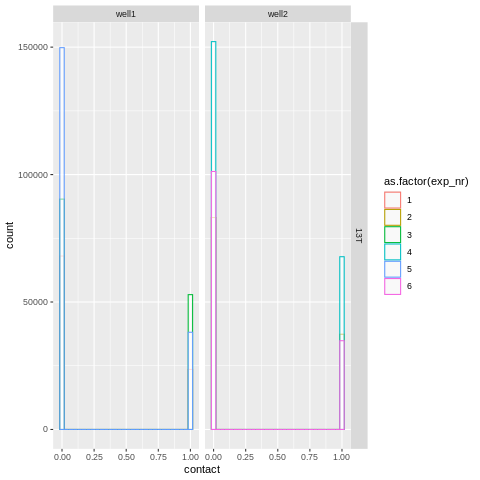

In [9]:
%%R
print(plot1)


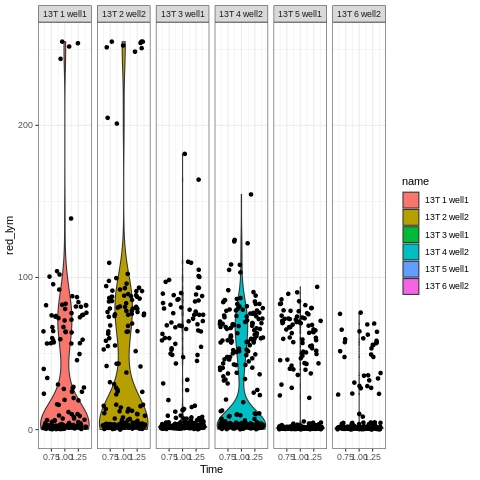

In [10]:
%%R
print(plot2)

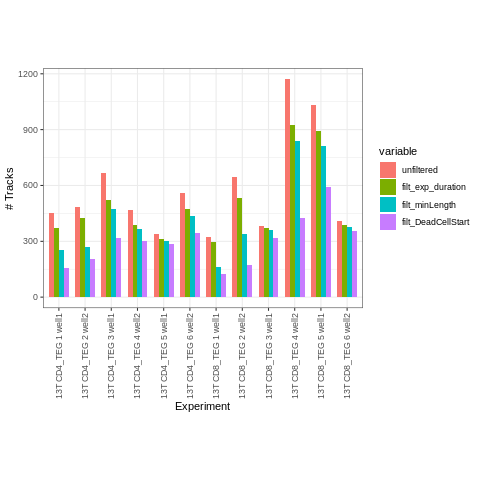

In [11]:
%%R
print(plot3)

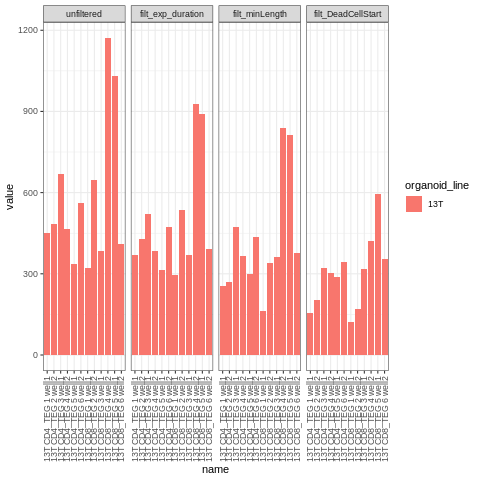

In [12]:
%%R
print(plot4)

#**If a MODEL ALREADY exists**, then provide the MODEL_PATH in the following space (else, skip this line).


In [ ]:
%%R
model_path <- "/content/drive/MyDrive/BEHAV3D-main/BEHAV3D-main/references/TrainedRandomForest.Rdata" #@param {type:"string"}


In [ ]:
%%R
install.packages('scales')
install.packages('randomForest')


(as ‘lib’ is unspecified)







	‘/tmp/RtmpkjPhIE/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpkjPhIE/downloaded_packages’



In [ ]:
%%R


print("#################################################")
print("#### Model_path defined, performing random forest classification...")
print("#################################################")
###############################
##### Behavior prediction #####
###############################

library(scales)
library(randomForest)
print(1)

# Load in the previously trained Random Forest model
tryCatch(
  {
    load(model_path)
  },
  error=function(e) {
    message("Provided model path does not exist")
    message("Please set the path to the provided Random Forest model or \ntrain it on your own reference set (see: 'train_randomforest')")
    message(paste("Provided model path:", model_path))
    message("\nHere's the original error message:")
    message(e)
    stop()
    # Choose a return value in case of error
  }
)

#### Import new dataset to predict behavior (e.g. import dataset called "master_corrected3_example")
master_test<-master_corrected3

### Normalize the data
master_test2<-master_test%>% ungroup()%>%
  # group_by(tcell_line, organoid_line, exp_nr, well) %>%
  group_by(exp_nr) %>%
  mutate(z.disp = (displacement-mean(displacement))/sd(displacement),z.speed = (speed-mean(speed))/sd(speed), z.red = (red_lym-mean(red_lym))/sd(red_lym))%>%
  mutate(q.disp=ifelse(z.disp>(quantile(z.disp, p=0.75)),z.disp,min(z.disp)), q.speed=ifelse(z.speed>(quantile(z.speed, p=0.75)),z.speed,min(z.speed)),q.red=ifelse(z.red>(quantile(z.red, p=0.75)),z.red,min(z.red)))%>%
  mutate(q.disp=scales::rescale(q.disp, to=c(0,100)),q.speed=scales::rescale(q.speed, to=c(0,100)),q.red=scales::rescale(q.red, to=c(0,100)),s.contact=scales::rescale(contact, to=c(0,1)),s.contact_lym=scales::rescale(contact_lym, to=c(0,1)))%>%
  mutate(q.disp=q.disp/mean(quantile(q.disp, p=0.9999)),q.speed=q.speed/mean(quantile(q.speed, p=0.9999)),q.red=q.red/mean(quantile(q.red, p=0.9999)))%>%
  ungroup()

### Calculate time-series descriptive statistics
test_dataset <- master_test2%>%group_by(TrackID)%>% arrange(Time)%>%
  summarise(mean_speed= mean(q.speed),median_speed= median(q.speed),speed_sd= sd(q.speed),q3_speed= quantile(q.speed,0.90),
            mean_displacement = mean(q.disp),median_displacement = median(q.disp),
            displacement_sd=sd(q.disp),q3_disp= quantile(q.disp,0.90),
            mean_red_lym = mean(q.red),red_lym_sd=sd(q.red),q3_red= quantile(q.red,0.90),
            contact=mean(s.contact),mean_contact2=mean(contact2),contact2=max(contact2))

### create a  matrix from the predictors
test1 = as.matrix(test_dataset[,-which(names(test_dataset) == "TrackID")])
model_predict_test<-predict(model,test1,type="response")
test_dataset_predicted<-cbind(model_predict_test,test_dataset)
test_dataset_predicted$cluster<-test_dataset_predicted$model_predict

### Plot the proportion of cells for each behavioral signature
## Join information of cell ID
classification<-test_dataset_predicted[,c(2,17)]
master_classified<-left_join(master_test,classification, by="TrackID")
cell_ID<-master_classified[!duplicated(master_classified$TrackID),c("TrackID","organoid_line","tcell_line","exp_nr", "well")]
saveRDS(master_classified, file = paste0(output_dir,"classified_tcell_track_data.rds"))

# Set the file names
rds_filename <- "classified_tcell_track_data.rds"
# Save the PDF and RDS files locally
rds_file <- file.path(getwd(), rds_filename)
saveRDS(master_classified, file = rds_file)  # Save the RDS file in the local directory


classified_tracks<-test_dataset_predicted
classified_tracks$cluster2<-classified_tracks$cluster
classified_tracks<-left_join(classified_tracks,cell_ID)
classified_tracks<-classified_tracks%>%arrange(cluster2)

saveRDS(classified_tracks, file = paste0(output_dir,"classified_tcell_track_data_summary.rds"))

# Set the file names
rds_filename <- "classified_tcell_track_data_summary.rds"
# Save the PDF and RDS files locally
rds_file <- file.path(getwd(), rds_filename)
saveRDS(classified_tracks, file = rds_file)  # Save the RDS file in the local directory

### Quantify the number of cells per well
Number_cell_exp<-classified_tracks%>%group_by(well, exp_nr, tcell_line, organoid_line)%>%
  summarise(total_cell = n())
Percentage_clus<-left_join(Number_cell_exp,classified_tracks)
Percentage_clus <- Percentage_clus%>%group_by(cluster2,tcell_line, well,exp_nr, organoid_line)%>%
  summarise(total_cell = mean(total_cell), num_cluster=n())%>%mutate(percentage=num_cluster*100/total_cell)%>%ungroup()

### Add clusters that don't exist for experiments to the percentage table
for (cluster in unique(Percentage_clus$cluster2)){
  for (row in 1:nrow(Percentage_clus)) {
    tcell_line = as.character(Percentage_clus[row, "tcell_line"])
    organoid_line = as.character(Percentage_clus[row, "organoid_line"])
    well = as.character(Percentage_clus[row, "well"])
    exp = as.integer(Percentage_clus[row, "exp_nr"])
    total_cell = as.integer(Number_cell_exp[
      Number_cell_exp$tcell_line==tcell_line &
        Number_cell_exp$well==well &
        Number_cell_exp$exp_nr==exp &
        Number_cell_exp$organoid_line==organoid_line, "total_cell"
    ])
    if (
      dim(
        Percentage_clus[Percentage_clus$cluster2==cluster &
                        Percentage_clus$tcell_line==tcell_line &
                        Percentage_clus$well==well &
                        Percentage_clus$exp_nr==exp &
                        Percentage_clus$organoid_line==organoid_line,]
      )[1]==0
    ){
      extra_row=data.frame(
        cluster2=cluster,
        tcell_line=tcell_line,
        well=well,
        exp_nr=exp,
        organoid_line=organoid_line,
        total_cell=total_cell,
        num_cluster=0,
        percentage=0
      )
      Percentage_clus<-rbind(Percentage_clus, extra_row)
    }
  }
}

saveRDS(Percentage_clus, file = paste0(output_dir,"cluster_perc_tcell_track_data.rds"))

# Set the file names
rds_filename <- "cluster_perc_tcell_track_data.rds"
# Save the PDF and RDS files locally
rds_file <- file.path(getwd(), rds_filename)
saveRDS(Percentage_clus, file = rds_file)  # Save the RDS file in the local directory

### Plot proportion per well and per cell type
Percentage_clus$tcell_line = as.factor(Percentage_clus$tcell_line)

Per<-ggplot(Percentage_clus, aes(fill=as.factor(cluster2), y=percentage, x="")) +
  geom_bar( stat="identity", position="fill")+ coord_flip()+ scale_y_reverse()
Per <- Per + facet_grid(interaction(exp_nr, well, organoid_line)  ~ tcell_line)

Per<-Per+theme_void() + scale_fill_manual(values=c("gold3",
                                                    "darkolivegreen3",
                                                    "seagreen3",
                                                    "forestgreen",
                                                    "dodgerblue",
                                                    "cyan1",
                                                    "indianred",
                                                    "firebrick",
                                                    "brown1"),drop = FALSE)+
  theme(aspect.ratio = 0.2,strip.text.x = element_text(angle = 90))

Per

ggsave(paste0(output_dir,"RF_ClassProp_WellvsCelltype.png"), device="png")
ggsave(paste0(output_dir,"RF_ClassProp_WellvsCelltype.pdf"), device="pdf")

# Set the file names
pdf_filename <- "RF_ClassProp_WellvsCelltype.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory


# Set the file names
png_filename <- "RF_ClassProp_WellvsCelltype.png"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), png_filename)
ggsave(pdf_file, device = "png")  # Save the PNG in the local directory


[1] "#################################################"
[1] "#### Model_path defined, performing random forest classification..."
[1] "#################################################"


Attaching package: ‘scales’



    rescale



    col_factor




Attaching package: ‘randomForest’



    margin



    combine




[1] 1
Joining with `by = join_by(TrackID)`
`summarise()` has grouped output by 'well', 'exp_nr', 'tcell_line'. You can
override using the `.groups` argument.
Joining with `by = join_by(well, exp_nr, tcell_line, organoid_line)`
`summarise()` has grouped output by 'cluster2', 'tcell_line', 'well', 'exp_nr'.
You can override using the `.groups` argument.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


##Plots

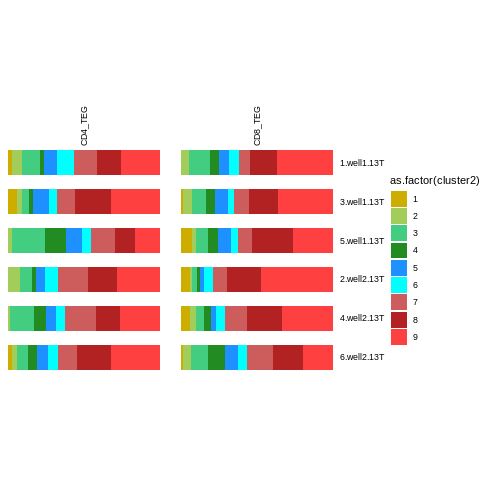

In [ ]:
%%R
print(Per)


#**If you DONT have a model**, then we will run unsupervised **UMAP** clustering. The parameters bellow are on default, feel free to change them if necesary. (**Behavioral reference map generation**, maybe it goes first)

In [13]:
%%R

umap_minimal_distance <- 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
umap_n_neighbors <- 5 #@param {type:"slider", min:0, max:50, step:1}
nr_of_clusters <- 6 #@param {type:"slider", min:0, max:50, step:1}

##Packages

In [14]:
%%R
install.packages('dplyr')
install.packages('dtwclust')
install.packages('stats')
install.packages('scales')
install.packages('parallel')
install.packages('RcppParallel')
install.packages('doParallel')
install.packages('umap')
install.packages('viridis')

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)




















































































	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)





























	‘/tmp/Rtmpd8QHbf/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/Rtmpd8QHbf/downloaded_packages’



##UMAP

In [20]:
%%R

print("#################################################")
print("#### Model_path NOT defined, performing UMAP clustering...")
print("#################################################")

#######################################################
###########     UNSUPERVISED CLUSTERING     ###########
#######################################################

library(dplyr)
#library(dtwclust)
library(stats)
library(scales)

master_processed<-master_corrected3%>%
  group_by(exp_nr) %>%
  mutate(z.disp = (displacement-mean(displacement))/sd(displacement),z.speed = (speed-mean(speed))/sd(speed), z.red = (red_lym-mean(red_lym))/sd(red_lym))%>%
  mutate(q.disp=ifelse(z.disp>(quantile(z.disp, p=0.75)),z.disp,min(z.disp)), q.speed=ifelse(z.speed>(quantile(z.speed, p=0.75)),z.speed,min(z.speed)),q.red=ifelse(z.red>(quantile(z.red, p=0.75)),z.red,min(z.red)))%>%
  mutate(q.disp=scales::rescale(q.disp, to=c(0,1)),q.speed=scales::rescale(q.speed, to=c(0,1)),q.red=scales::rescale(q.red, to=c(0,1)),s.contact=scales::rescale(contact, to=c(0,1)),s.contact_lym=scales::rescale(contact_lym, to=c(0,1))) %>%
  mutate(q.disp=q.disp/mean(quantile(q.disp, p=0.9999999)),q.speed=q.speed/mean(quantile(q.speed, p=0.9999999)),q.red=q.red/mean(quantile(q.red, p=0.9999999)))%>%ungroup()
print("1")

### Arrange data by time:
master_processed<-master_processed%>%group_by(TrackID)%>%arrange(Time)
master_processed$TrackID = as.character(master_processed$TrackID)
# master_processed_ref<-master_processed_ref%>%group_by(TrackID)%>%arrange(Time)
print("2")

saveRDS(master_processed, file = paste0(output_dir,"tcell_track_features.rds"))


# Set the file names
rds_filename <- "tcell_track_features.rds"
# Save the PDF and RDS files locally
rds_file <- file.path(getwd(), rds_filename)
saveRDS(master_processed, file = rds_file)  # Save the RDS file in the local directory

###Split the data in a list of TrackIDs with multivariate data for each Track overtime
list_multivariate <- split(master_processed[,c("q.disp", "q.speed", "q.red","s.contact", "s.contact_lym")],master_processed$TrackID)

list_multivariate_save <- list_multivariate
#list_multivariate <- list_multivariate[1:15]
print("3")


##Set up parallel working for big datasets
library(parallel)
#library(dtwclust)
library(RcppParallel)
# create multi-process workers
#workers <- parallel::makeCluster(detectCores() - 2)
workers <- parallel::makeCluster(3)
# load dtwclust in each one, and make them use 1 thread per worker
invisible(parallel::clusterEvalQ(workers, {
  library(dtwclust)
  RcppParallel::setThreadOptions(1L)
}))
print("4")

# register your workers, e.g. with doParallel
require(doParallel)
registerDoParallel(workers)
print("5")


###MULTIVARIATE cross-distance matrix calculate for different tracks
distmat <- proxy::dist(list_multivariate, method = "dtw")
matrix_distmat<-as.matrix(distmat)
## Store TrackID names
TrackID<-as.character(names(list_multivariate))
print("6")

library(umap)
## Project cross-distance matrix in a UMAP
umap_dist<- umap(matrix_distmat,n_components=2,input="dist",init = "random",
                  n_neighbors=umap_n_neighbors, min_dist=umap_minimal_distance, spread=1)  ### adjust parameters
#Visualize plot
pdf(file=paste0(output_dir,"Umap_unclustered.pdf"))

# Set the file names
pdf_filename <- "Umap_unclustered.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory

plot(umap_dist$`layout`,
      col=rgb(0,0,0,alpha=0.1),
      pch=19,
      asp=0.4)

dev.off()
print("7")

umap_1 <- as.data.frame(umap_dist$`layout`)

Track2_umap<-cbind(TrackID,umap_1)
temp_df<-master_corrected3[,c("TrackID", "well","exp_nr","organoid_line")]
temp_df<- temp_df[!duplicated(temp_df$TrackID),]
umap_2 <- left_join(Track2_umap ,temp_df)
print("8")

## Perform clustering. Select clusterig type that suits more your dataset

km.norm <- kmeans(umap_dist$`layout`,nr_of_clusters, nstart = 100)
umap_3 <- cbind(km.norm$cluster, umap_2)
colnames(umap_3)[1]<- "cluster2"
## remove the outlier cluster if necessary
umap_3<-subset(umap_3, cluster2!=0)

print("9")

plot9<-ggplot(umap_3, aes(x=V1, y=V2, color=as.factor(cluster2))) +
  geom_point(size=2, alpha=0.6) + labs(color="cluster")+
  xlab("") + ylab("")+
  ggtitle("umap Cluster ") +
  theme_light(base_size=20) +theme_bw()+
  theme(axis.text.x=element_blank(),
        axis.text.y=element_blank(), aspect.ratio=1)+coord_fixed()

ggsave(
  paste0(output_dir,"Umap_clustered.pdf"),
  device="pdf", height=210, width=297, units="mm"
)

# Set the file names
pdf_filename <- "Umap_clustered.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory


#### To the original dataset add information on cluster type
master_clustered <- merge(master_processed ,umap_3[c("TrackID","cluster2")], by.x = "TrackID", by.y = "TrackID")
# master_clustered$cluster = master_clustered$cluster2
### Save Reference UMAP for training of random forest classifier
saveRDS(master_clustered, file = paste0(output_dir,"behavioral_reference_map.rds")) ### store here your reference map that can be used to predict behaviors in new experiments

## Plot a heatmap to show the relative values of each behavior parameter
## Create a dataframe the summarizes the mean values for each parameter
sum_all <- master_clustered%>% select( speed, displacement, red_lym, contact2, contact_lym, cluster2, contact)%>% group_by(cluster2)%>%
  summarise(contact_len=mean(contact2),n_contact_org= mean(contact),displacement2 = median(displacement), speed = median(speed), interaction_T_cells= mean(contact_lym),death = median(red_lym))
## scales::rescale the values from each parameter
sum_all <- sum_all%>%mutate(contact_len= scales::rescale(contact_len, to=c(0,100)) ,n_contact_org= scales::rescale(n_contact_org, to=c(0,100)),displacement2 = scales::rescale(displacement2, to=c(0,100)), speed = scales::rescale(speed, to=c(0,100)),interaction_T_cells= scales::rescale(interaction_T_cells, to=c(0,100)), death =scales::rescale(death, to=c(0,100)))

## Reshape dataframe
library(reshape2)
library(viridis)
sum_all<-melt(sum_all,id.vars = "cluster2")
sum_all$cluster2<-as.factor(sum_all$cluster2)
## Plot heatmap
gg <- ggplot(data = sum_all, aes(x = variable, cluster2, fill = value))
gg <- gg + geom_tile()
gg <- gg + scale_fill_viridis(option="C", name="AU")
gg <- gg + labs(x=NULL, y="Cluster", title="cluster represention")+theme(aspect.ratio=1.7,axis.text.x = element_text(angle = 45, hjust = 1))+ylim(rev(levels(sum_all$cluster2)))
gg

ggsave(
  paste0(output_dir,"Cluster_heatmap.pdf"),
  device="pdf", height=210, width=297, units="mm"
)

# Set the file names
pdf_filename <- "Cluster_heatmap.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory

master_clustered_info<-master_clustered[!duplicated(master_clustered$TrackID),c("TrackID","organoid_line","tcell_line","exp_nr", "well", "cluster2")]

master_clustered2 =master_clustered%>%group_by(TrackID)%>% arrange(Time)%>%
                    summarise(mean_speed= mean(q.speed),median_speed= median(q.speed),speed_sd= sd(q.speed),q3_speed= quantile(q.speed,0.90),
                              mean_displacement = mean(q.disp),median_displacement = median(q.disp),
                              displacement_sd=sd(q.disp),q3_disp= quantile(q.disp,0.90),
                              mean_red_lym = mean(q.red),red_lym_sd=sd(q.red),q3_red= quantile(q.red,0.90),
                              contact=mean(s.contact),mean_contact2=mean(contact2),contact2=max(contact2))

master_clustered2<-left_join(master_clustered2,master_clustered_info)


### Quantify the number of cells per well
Number_cell_exp<-master_clustered2%>%group_by(well, exp_nr, tcell_line, organoid_line)%>%
  summarise(total_cell = n())
Percentage_clus<-left_join(Number_cell_exp, master_clustered2)
Percentage_clus <- Percentage_clus%>%group_by(cluster2,tcell_line, well,exp_nr, organoid_line)%>%
  summarise(total_cell = mean(total_cell), num_cluster=n())%>%mutate(percentage=num_cluster*100/total_cell)%>%ungroup()

Per1<-ggplot(Percentage_clus, aes(fill=as.factor(cluster2), y=percentage, x="")) +
  geom_bar( stat="identity", position="fill")+ coord_flip()+ scale_y_reverse()
Per1 <- Per1 + facet_grid(interaction(exp_nr,well,organoid_line)  ~ tcell_line)
# Per1 <- Per1 + facet_grid(exp_nr + well + organoid_line  ~ tcell_line)

# Per1 <- Per1 + facet_grid(interaction(exp_nr,well,organoid_line)  ~ interaction(organoid_line,tcell_line))
Per1<-Per1+theme_void() +
  theme(aspect.ratio = 0.2,strip.text.x = element_text(angle = 90))

Per1

ggsave(
  paste0(output_dir,"umap_cluster_percentage_bars_separate.pdf"),
  device="pdf", height=210, width=297, units="mm"
)

# Set the file names
pdf_filename <- "umap_cluster_percentage_bars_separate.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory

############### Combine all wells
Number_cell_exp_combined<-master_clustered2%>%group_by(exp_nr, tcell_line, organoid_line)%>%
  summarise(total_cell = n())
Percentage_clus_combined<-left_join(Number_cell_exp_combined,master_clustered2)
Percentage_clus_combined <- Percentage_clus_combined%>%group_by(cluster2,exp_nr, tcell_line, organoid_line)%>%
  summarise(total_cell = mean(total_cell), num_cluster=n())%>%mutate(percentage=num_cluster*100/total_cell)%>%ungroup()

Per<-ggplot(Percentage_clus_combined, aes(fill=as.factor(cluster2), y=percentage, x="")) +
  geom_bar( stat="identity", position="fill")+ coord_flip()+ scale_y_reverse()
Per <- Per + facet_grid(interaction(exp_nr,organoid_line)  ~ tcell_line)
# Per <- Per + facet_grid(exp_nr + well + organoid_line  ~ tcell_line)

# Per <- Per + facet_grid(interaction(exp_nr,well,organoid_line)  ~ interaction(organoid_line,tcell_line))
Per<-Per+theme_void() +
  theme(aspect.ratio = 0.2,strip.text.x = element_text(angle = 90))

Per

ggsave(
  paste0(output_dir,"umap_cluster_percentage_bars_combined.pdf"),
  device="pdf", height=210, width=297, units="mm"
)

# Set the file names
pdf_filename <- "umap_cluster_percentage_bars_combined.pdf"
# Save the PDF and RDS files locally
pdf_file <- file.path(getwd(), pdf_filename)
ggsave(pdf_file, device = "pdf")  # Save the PDF in the local directory


[1] "#################################################"
[1] "#### Model_path NOT defined, performing UMAP clustering..."
[1] "#################################################"
[1] "1"
[1] "2"
[1] "3"
[1] "4"


[1] "5"
[1] "6"

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    Saving 7 x 7 in image
[1] "7"
Joining with `by = join_by(TrackID)`
[1] "8"
[1] "9"
Saving 6.67 x 6.67 in image



Attaching package: ‘viridis’



    viridis_pal




Saving 6.67 x 6.67 in image
Joining with `by = join_by(TrackID)`
`summarise()` has grouped output by 'well', 'exp_nr', 'tcell_line'. You can
override using the `.groups` argument.
Joining with `by = join_by(well, exp_nr, tcell_line, organoid_line)`
`summarise()` has grouped output by 'cluster2', 'tcell_line', 'well', 'exp_nr'.
You can override using the `.groups` argument.
Saving 6.67 x 6.67 in image
`summarise()` has grouped output by 'exp_nr', 'tcell_line'. You can override
using the `.groups` argument.
Joining with `by = join_by(exp_nr, tcell_line, organoid_line)`
`summarise()` has grouped output by 'cluster2', 'exp_nr', 'tcell_line'. You can
override using the `.groups` argument.
Saving 6.67 x 6.67 in image


In [ ]:
%%R
# Instalar el paquete metagMisc
# Suponiendo que distmat es la matriz que quieres imprimir

# Imprimir las primeras 15 filas

distmat



              1_1000570533 1_1000570535 1_1000570536 1_1000570537 1_1000570541
1_1000570535  3.946399e+00                                                    
1_1000570536  2.398879e+01 1.939798e+01                                       
1_1000570537  6.230376e-01 3.018585e+00 1.984509e+01                          
1_1000570541  2.437221e+01 2.178225e+01 3.313306e+01 2.460458e+01             
1_1000570545  1.031078e+00 3.890164e+00 2.263763e+01 1.040277e+00 2.527239e+01
1_1000570547  8.031977e+00 9.833493e+00 2.309437e+01 7.272628e+00 2.203420e+01
1_1000570549  1.996290e+00 3.604572e+00 2.028448e+01 1.055579e+00 2.571579e+01
1_1000570554  7.442677e+01 7.247522e+01 7.527514e+01 7.400237e+01 5.627905e+01
1_1000570555  1.475090e+01 1.425392e+01 2.391390e+01 1.437974e+01 2.865066e+01
1_1000570557  3.188470e+01 3.097405e+01 3.764772e+01 2.998006e+01 4.277036e+01
1_1000570558  2.232070e+01 1.939531e+01 3.540508e+01 2.001735e+01 2.197098e+01
1_1000570561  9.411382e+00 1.084220e+01 2.194346e+01

Exception ignored from cffi callback <function _consolewrite_ex at 0x7b341c0d1ea0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 136, in _consolewrite_ex
    consolewrite_print(s)
  File "/usr/local/lib/python3.10/dist-packages/rpy2/rinterface_lib/callbacks.py", line 119, in consolewrite_print
    print(s, end='', flush=True)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 342, in flush
    self.pub_thread.schedule(self._flush)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 203, in schedule
    self._event_pipe.send(b'')
  File "/usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py", line 618, in send
    return super().send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 740, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 787, in zmq.backend.cython.socket.Socket.send


1_1000570573                                                         
1_1000570575                                                         
1_1000570581                                                         
1_1000570584                                                         
1_1000570585                                                         
1_1000570589                                                         
              12_1000111771 12_1000111962 12_1000112033 12_1000112334
1_1000570535                                                         
1_1000570536                                                         
1_1000570537                                                         
1_1000570541                                                         
1_1000570545                                                         
1_1000570547                                                         
1_1000570549                                                         
1_1000570554       

##Plots

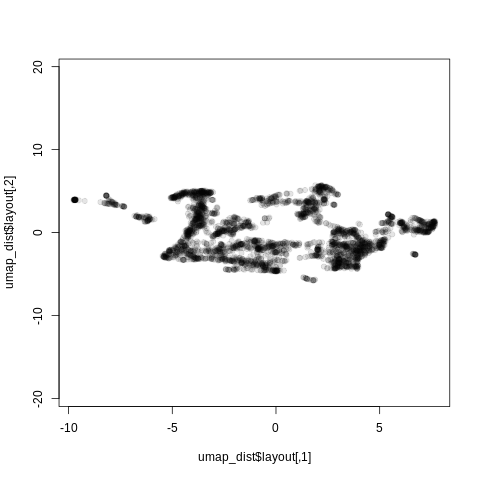

In [21]:
#@title
%%R
plot(umap_dist$`layout`,
      col=rgb(0,0,0,alpha=0.1),
      pch=19,
      asp=0.4)

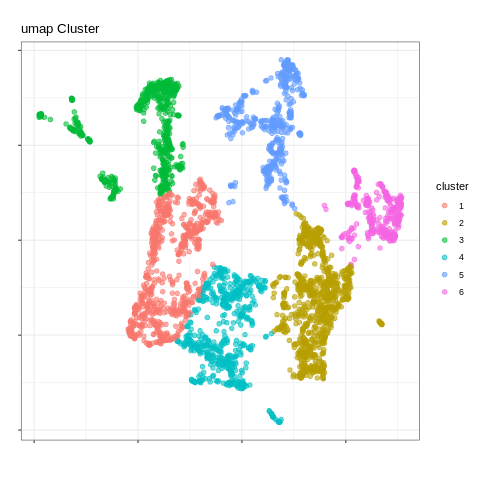

In [22]:
#@title
%%R
print(plot9)

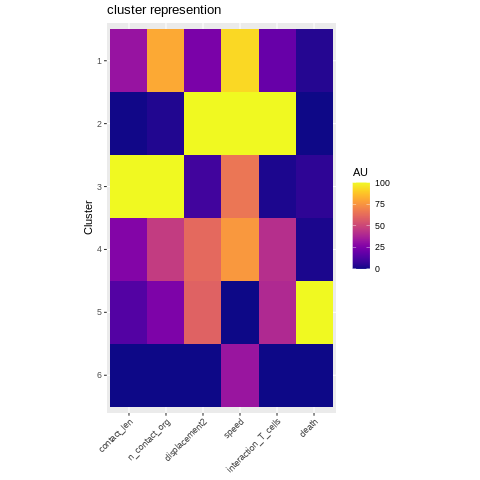

In [23]:
#@title
%%R
print(gg)

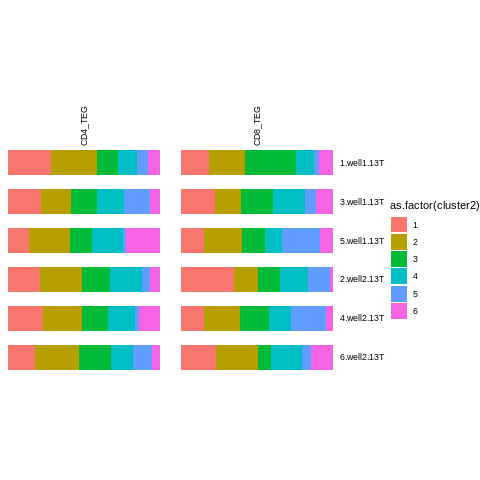

In [24]:
#@title
%%R
print(Per1)

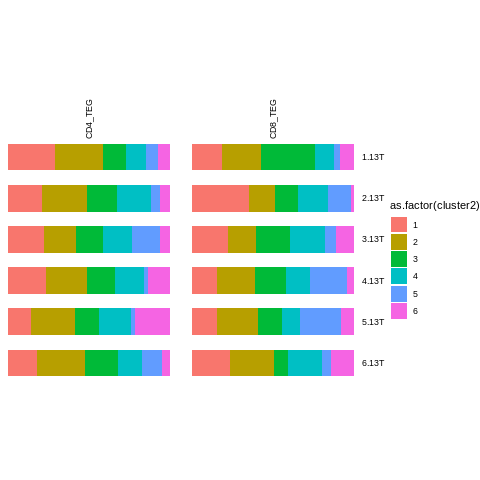

In [25]:
#@title
%%R
print(Per)

#If you want to **download the generated files until now as a zip to your local** computer, do the following:
###1) Run this code
###2) Right click on the generated file named "my_folder.zip" and click on download. Like in the image:
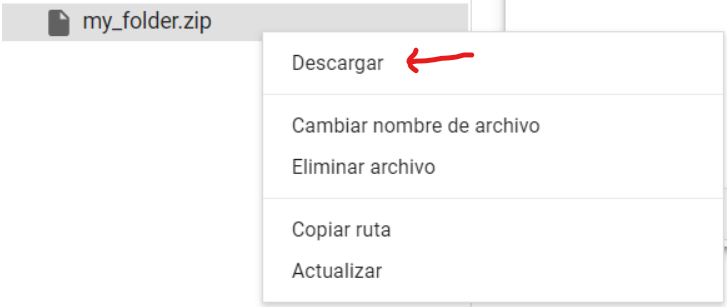

In [27]:
%%R

#Generating the folder
folder_name <- "my_folder"
dir.create(folder_name)

# Get a list of all files in the current directory
file_list <- list.files()

# Exclude files named "drive" or "sample_data"
files_to_move <- file_list[!(file_list %in% c("drive", "sample_data"))]

# Move files to the new folder
for (file in files_to_move) {
  file_path <- file
  new_path <- paste0(folder_name, "/", file)
  file.rename(file_path, new_path)
}

zip_file_path <- paste0(folder_name, ".zip")
zip(zip_file_path, files = list.files(folder_name, recursive = TRUE, full.names = TRUE))


